# Creating a Databunch for Basecalling

In [63]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [64]:
import functools

from fastai.basics import *

import jkbc.utils.preprocessing as prep
import jkbc.utils.postprocessing as pop
import jkbc.utils.files as f
import jkbc.types as t
import jkbc.utils.loss as loss


## Constants

In [65]:
BLANK_ID = prep.BLANK_ID
C = 5
D_in = 300
D_out_max = 70
n_hidden = 200
BS = 256  # batch size
LR = 0.05
NF = 256 # features in residualblock

#DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0")

## Load Data

In [66]:
base_dir = "data/feather-files/"
path_data = Path(base_dir)
data_set_name = f'Range0-100-FixLabelLen{D_out_max}'
feather_folder = path_data/data_set_name

In [67]:
# Read data from feather
data = f.read_data_from_feather_file(feather_folder)

# Convert to databunch
train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=True)
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)

## Model

In [68]:
loss_func = loss.ctc_loss(NF, BS, C)

In [174]:
NF = 123
def conv(ni, nf, ks):
    padding = ks//2
    return nn.Conv1d(ni, nf, kernel_size=ks, stride=1, padding=padding)

def ConvLayer(ni, nf, ks):
    return nn.Sequential(
        conv(ni, nf, ks)
        ,nn.BatchNorm1d(nf)
        ,nn.ReLU()
    )

def ConvBlock(a, b, c, ni, nf):
    return nn.Sequential(
        ConvLayer(ni, nf, a)
    )

class ResidualBlock(nn.Module):
    def __init__(self, a, b, c, ni, nf):
        super().__init__()
        self.module = ConvBlock(a, b, c, ni, nf)
        self.residual = ConvBlock(a, b, c, ni, nf)
    
    def forward(self, x):
        out_a = self.module(x)
        out_b = self.residual(x)
        
        return nn.ReLU()(out_a + out_b)

model = nn.Sequential(
    ResidualBlock(2+1, 2^2+1, 2^3+1, 1, NF)
    ,ResidualBlock(2^2+1, 2^5+1, 2^6+1, NF, NF)
    ,ResidualBlock(2^3+1, 2^8+1, 2^8+1, NF, NF)
    ,ResidualBlock(2^4+1, 2^8+1, 2^8+1, NF, NF)
    ,ResidualBlock(2^5+1, 2^8+1, 2^8+1, NF, NF)
    ,ResidualBlock(2^6+1, 2^8+1, 2^8+1, NF, NF)
    ,nn.Linear(D_in+2, 5)
    ,nn.LogSoftmax(dim=2)
).to(device=DEVICE)

In [229]:
learner = Learner(databunch, model, loss_func=loss_func)

In [147]:
learner = learner.load('CNN')

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.module.0.0.weight", "0.module.0.0.bias", "0.module.0.1.weight", "0.module.0.1.bias", "0.module.0.1.running_mean", "0.module.0.1.running_var", "0.module.1.0.weight", "0.module.1.0.bias", "0.module.1.1.weight", "0.module.1.1.bias", "0.module.1.1.running_mean", "0.module.1.1.running_var", "0.residual.weight", "0.residual.bias", "1.weight", "1.bias". 
	Unexpected key(s) in state_dict: "3.weight", "3.bias", "0.0.0.weight", "0.0.0.bias", "0.0.1.weight", "0.0.1.bias", "0.0.1.running_mean", "0.0.1.running_var", "0.0.1.num_batches_tracked", "0.1.0.weight", "0.1.0.bias", "0.1.1.weight", "0.1.1.bias", "0.1.1.running_mean", "0.1.1.running_var", "0.1.1.num_batches_tracked", "0.2.0.weight", "0.2.0.bias", "0.2.1.weight", "0.2.1.bias", "0.2.1.running_mean", "0.2.1.running_var", "0.2.1.num_batches_tracked", "1.0.0.weight", "1.0.0.bias", "1.0.1.weight", "1.0.1.bias", "1.0.1.running_mean", "1.0.1.running_var", "1.0.1.num_batches_tracked", "1.1.0.weight", "1.1.0.bias", "1.1.1.weight", "1.1.1.bias", "1.1.1.running_mean", "1.1.1.running_var", "1.1.1.num_batches_tracked", "1.2.0.weight", "1.2.0.bias", "1.2.1.weight", "1.2.1.bias", "1.2.1.running_mean", "1.2.1.running_var", "1.2.1.num_batches_tracked", "2.0.0.weight", "2.0.0.bias", "2.0.1.weight", "2.0.1.bias", "2.0.1.running_mean", "2.0.1.running_var", "2.0.1.num_batches_tracked", "2.1.0.weight", "2.1.0.bias", "2.1.1.weight", "2.1.1.bias", "2.1.1.running_mean", "2.1.1.running_var", "2.1.1.num_batches_tracked", "2.2.0.weight", "2.2.0.bias", "2.2.1.weight", "2.2.1.bias", "2.2.1.running_mean", "2.2.1.running_var", "2.2.1.num_batches_tracked". 

epoch,train_loss,valid_loss,time
0,6.313816,#na#,00:06


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 5.25E-02


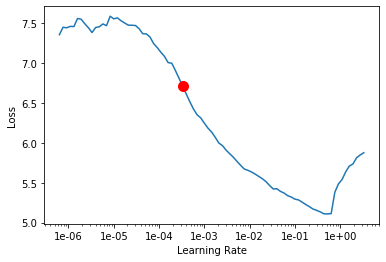

In [230]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [232]:
learner.fit_one_cycle(10, max_lr=3e-4)

epoch,train_loss,valid_loss,time
0,3.742536,4.556297,00:07
1,3.768437,4.752322,00:07
2,3.800988,4.730158,00:07
3,3.798256,4.693400,00:07
4,3.771749,4.692694,00:07
5,3.733126,4.608558,00:07
6,3.682818,4.785477,00:07
7,3.623072,4.755531,00:07
8,3.547312,4.725859,00:07
9,3.483608,4.731873,00:07


In [116]:
learner.save('CNN')

In [191]:
x, (y, _) = databunch.one_batch()
y_pred = model(x.to(device=DEVICE)).detach().cpu().numpy()
len(y_pred[0]), len(y_pred[0][0])

(256, 5)

In [192]:
index = 0
actual = pop.convert_idx_to_base_sequence(y[index])
print(actual)
for beam in range(5, 35):
    decoded = pop.decode(y_pred, threshold=.01, beam_size=beam)   
    predicted = decoded[index]
    error = pop.calc_sequence_error_metrics(actual, predicted)
    print(predicted, beam, error.error)
    del predicted

CGACATCGAGGTGCCAAACCTCC
AAAAAAAA 5 0.8695652173913043
AAAAAAAAA 6 0.8695652173913043
AAAAAAAAAA 7 0.8695652173913043
AAAAAAAAAA 8 0.8695652173913043
AAAAAAAAAA 9 0.8695652173913043
AAAAAAAAAA 10 0.8695652173913043
AAAAAAAAAA 11 0.8695652173913043
AAAAAAAAAA 12 0.8695652173913043
AAAAAAAAAA 13 0.8695652173913043
AAAAAAAAAAA 14 0.8695652173913043
AAAAAAAAAAA 15 0.8695652173913043
AAAAAAAAAA 16 0.8695652173913043
AAAAAAAAAAA 17 0.8695652173913043
AAAAAAAAAAA 18 0.8695652173913043
AAAAAAAAAAA 19 0.8695652173913043
AAAAAAAAAAA 20 0.8695652173913043
AAAAAAAAAAA 21 0.8695652173913043
AAAAAAAAAAA 22 0.8695652173913043
AAAAAAAAAAA 23 0.8695652173913043
AAAAAAAAAAA 24 0.8695652173913043
AAAAAAAAAAA 25 0.8695652173913043
AAAAAAAAAAA 26 0.8695652173913043
AAAAAAAAAAA 27 0.8695652173913043
AAAAAAAAAAA 28 0.8695652173913043
AAAAAAAAAAA 29 0.8695652173913043
AAAAAAAAAAA 30 0.8695652173913043
AAAAAAAAAAA 31 0.8695652173913043
AAAAAAAAAAA 32 0.8695652173913043
ATAAAAAAAAAA 33 0.7826086956521738
AAAAAAA